In [1]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import xception, resnet50, vgg16, vgg19, inception_v3
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.inception_v3 import InceptionV3
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

# ==============================================================================
# STAGE 1: LOADING AND PREPROCESSING FOR PREDICTIONS
# ==============================================================================

def load_and_preprocess_image(image_path, model_name):
    """
    Load and preprocess image according to the specific model requirements.
    
    Returns:
        preprocessed_img: Ready for model.predict() - shape (1, H, W, 3)
        original_img: Original image array for visualization - shape (H, W, 3)
    """
    
    # Define input sizes for each model
    input_sizes = {
        'xception': (299, 299),
        'inception_v3': (299, 299),
        'resnet50': (224, 224),
        'vgg16': (224, 224),
        'vgg19': (224, 224)
    }
    
    # Define preprocessing functions for each model
    preprocess_functions = {
        'xception': xception.preprocess_input,
        'inception_v3': inception_v3.preprocess_input,
        'resnet50': resnet50.preprocess_input,
        'vgg16': vgg16.preprocess_input,
        'vgg19': vgg19.preprocess_input
    }
    
    size = input_sizes[model_name.lower()]
    preprocess_fn = preprocess_functions[model_name.lower()]
    
    # Load image
    img = image.load_img(image_path, target_size=size)
    
    # Convert to array - shape (H, W, 3), values [0, 255]
    img_array = image.img_to_array(img)
    
    # Keep a copy for visualization (values in [0, 255])
    original_img = img_array.copy()
    
    # Add batch dimension - shape (1, H, W, 3)
    img_batch = np.expand_dims(img_array, axis=0)
    
    # Apply model-specific preprocessing
    preprocessed_img = preprocess_fn(img_batch)
    
    return preprocessed_img, original_img


# ==============================================================================
# STAGE 2: MAKING PREDICTIONS
# ==============================================================================

def get_predictions(model, preprocessed_img, model_name, decode_fn, top_k=5):
    """
    Get model predictions and decode them to class names.
    
    Args:
        model: Keras model
        preprocessed_img: Preprocessed image from load_and_preprocess_image
        model_name: Name of the model (for reference)
        decode_fn: Decoding function (e.g., resnet50.decode_predictions)
        top_k: Number of top predictions to return
    """
    # Get predictions - shape (1, 1000)
    preds = model.predict(preprocessed_img)
    
    # Decode predictions
    decoded_preds = decode_fn(preds, top=top_k)[0]
    
    print(f"\n{model_name} Predictions:")
    for i, (imagenet_id, label, score) in enumerate(decoded_preds):
        print(f"  {i+1}. {label}: {score*100:.2f}%")
    
    return preds, decoded_preds


# ==============================================================================
# STAGE 3: LIME EXPLANATION
# ==============================================================================

def create_lime_explainer_function(model, model_name):
    """
    Create a prediction function for LIME that handles preprocessing.
    
    CRITICAL: LIME passes images in [0, 1] range, but models need their 
    specific preprocessing. This function bridges that gap.
    """
    
    preprocess_functions = {
        'xception': xception.preprocess_input,
        'inception_v3': inception_v3.preprocess_input,
        'resnet50': resnet50.preprocess_input,
        'vgg16': vgg16.preprocess_input,
        'vgg19': vgg19.preprocess_input
    }
    
    preprocess_fn = preprocess_functions[model_name.lower()]
    
    def predict_fn(images):
        """
        Prediction function for LIME.
        
        Args:
            images: numpy array of shape (n_samples, H, W, 3) with values in [0, 1]
        
        Returns:
            predictions: numpy array of shape (n_samples, 1000)
        """
        # LIME gives us images in [0, 1], convert to [0, 255]
        images_255 = images * 255.0
        
        # Apply model-specific preprocessing
        preprocessed = preprocess_fn(images_255)
        
        # Get predictions
        preds = model.predict(preprocessed, verbose=0)
        
        return preds
    
    return predict_fn


def explain_prediction(original_img, model, model_name, class_index, num_samples=1000):
    """
    Generate LIME explanation for a specific class prediction.
    
    Args:
        original_img: Original image array from load_and_preprocess_image - shape (H, W, 3), values [0, 255]
        model: Keras model
        model_name: Name of the model
        class_index: Index of the class to explain
        num_samples: Number of samples for LIME (more = better but slower)
    
    Returns:
        explanation: LIME explanation object
    """
    # LIME expects images in [0, 1] range
    img_for_lime = original_img / 255.0
    
    # Create LIME explainer
    explainer = lime_image.LimeImageExplainer()
    
    # Create prediction function with proper preprocessing
    predict_fn = create_lime_explainer_function(model, model_name)
    
    # Generate explanation
    explanation = explainer.explain_instance(
        img_for_lime,
        predict_fn,
        top_labels=5,
        hide_color=0,
        num_samples=num_samples
    )
    
    return explanation


# ==============================================================================
# STAGE 4: VISUALIZATION
# ==============================================================================

def visualize_explanation(original_img, explanation, class_index, class_name):
    """
    Visualize LIME explanation with positive and negative contributions.
    
    Args:
        original_img: Original image array - shape (H, W, 3), values [0, 255]
        explanation: LIME explanation object
        class_index: Index of the class to explain
        class_name: Name of the class for the title
    """
    # For visualization, we need image in [0, 1]
    img_for_viz = original_img / 255.0
    
    # Get image and mask for positive contributions (supporting the prediction)
    temp, mask = explanation.get_image_and_mask(
        class_index, 
        positive_only=True, 
        num_features=5, 
        hide_rest=False
    )
    
    # Get image and mask for negative contributions (against the prediction)
    temp_neg, mask_neg = explanation.get_image_and_mask(
        class_index, 
        positive_only=False, 
        num_features=10, 
        hide_rest=False
    )
    
    # Create visualization
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Original image
    axes[0].imshow(img_for_viz)
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    # Positive contributions (green boundaries)
    axes[1].imshow(mark_boundaries(temp, mask))
    axes[1].set_title(f'Positive Evidence for "{class_name}"')
    axes[1].axis('off')
    
    # All contributions (positive and negative)
    axes[2].imshow(mark_boundaries(temp_neg, mask_neg))
    axes[2].set_title('All Contributing Regions')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()


# ==============================================================================
# COMPLETE WORKFLOW EXAMPLE
# ==============================================================================

def complete_lime_workflow(image_path, model_name='resnet50'):
    """
    Complete workflow: load image, predict, explain, visualize.
    
    Args:
        image_path: Path to the image file
        model_name: One of 'xception', 'inception_v3', 'resnet50', 'vgg16', 'vgg19'
    """
    print(f"Starting LIME workflow with {model_name.upper()}...")
    
    # Load model
    models = {
        'xception': (Xception(weights='imagenet'), xception.decode_predictions),
        'inception_v3': (InceptionV3(weights='imagenet'), inception_v3.decode_predictions),
        'resnet50': (ResNet50(weights='imagenet'), resnet50.decode_predictions),
        'vgg16': (VGG16(weights='imagenet'), vgg16.decode_predictions),
        'vgg19': (VGG19(weights='imagenet'), vgg19.decode_predictions)
    }
    
    model, decode_fn = models[model_name.lower()]
    print(f"✓ Loaded {model_name} model")
    
    # Stage 1: Load and preprocess
    preprocessed_img, original_img = load_and_preprocess_image(image_path, model_name)
    print(f"✓ Loaded and preprocessed image")
    
    # Stage 2: Get predictions
    preds, decoded_preds = get_predictions(model, preprocessed_img, model_name, decode_fn)
    
    # Get top prediction
    top_class_index = np.argmax(preds[0])
    top_class_name = decoded_preds[0][1]
    
    # Stage 3: Generate LIME explanation
    print(f"\n✓ Generating LIME explanation for '{top_class_name}'...")
    explanation = explain_prediction(original_img, model, model_name, top_class_index)
    
    # Stage 4: Visualize
    print(f"✓ Creating visualization...")
    visualize_explanation(original_img, explanation, top_class_index, top_class_name)
    
    print(f"\n✓ Workflow complete!")
    
    return model, explanation


# ==============================================================================
# USAGE EXAMPLES
# ==============================================================================

if __name__ == "__main__":
    # Example usage for different models
    image_path = "path/to/your/image.jpg"
    
    # Try with different models
    # model, explanation = complete_lime_workflow(image_path, 'resnet50')
    # model, explanation = complete_lime_workflow(image_path, 'vgg16')
    # model, explanation = complete_lime_workflow(image_path, 'inception_v3')
    
    pass


# ==============================================================================
# QUICK REFERENCE: IMAGE FORMATS AT EACH STAGE
# ==============================================================================
"""
STAGE 1: LOADING
- Load with keras.preprocessing.image.load_img()
- Convert to array: shape (H, W, 3), dtype float32, range [0, 255]

STAGE 2: PREDICTION
- Add batch dimension: shape (1, H, W, 3)
- Apply model-specific preprocessing:
  * Xception/InceptionV3: Scales to [-1, 1]
  * ResNet50/VGG16/VGG19: BGR + mean subtraction (caffe style)

STAGE 3: LIME INPUT
- LIME expects: shape (H, W, 3), range [0, 1]
- LIME's prediction function receives: shape (n, H, W, 3), range [0, 1]
- Inside prediction function: Convert back to [0, 255] then apply preprocessing

STAGE 4: VISUALIZATION
- For matplotlib: shape (H, W, 3), range [0, 1]
- Original image / 255.0 for display

KEY INSIGHT:
Each model has its own preprocess_input() function that handles the specific
transformations it was trained with. ALWAYS use these functions instead of
manual normalization!
"""

"\nSTAGE 1: LOADING\n- Load with keras.preprocessing.image.load_img()\n- Convert to array: shape (H, W, 3), dtype float32, range [0, 255]\n\nSTAGE 2: PREDICTION\n- Add batch dimension: shape (1, H, W, 3)\n- Apply model-specific preprocessing:\n  * Xception/InceptionV3: Scales to [-1, 1]\n  * ResNet50/VGG16/VGG19: BGR + mean subtraction (caffe style)\n\nSTAGE 3: LIME INPUT\n- LIME expects: shape (H, W, 3), range [0, 1]\n- LIME's prediction function receives: shape (n, H, W, 3), range [0, 1]\n- Inside prediction function: Convert back to [0, 255] then apply preprocessing\n\nSTAGE 4: VISUALIZATION\n- For matplotlib: shape (H, W, 3), range [0, 1]\n- Original image / 255.0 for display\n\nKEY INSIGHT:\nEach model has its own preprocess_input() function that handles the specific\ntransformations it was trained with. ALWAYS use these functions instead of\nmanual normalization!\n"

Starting LIME workflow with RESNET50...
96112376/96112376 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
✓ Loaded ResNet50 model
✓ Loaded and preprocessed image
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

ResNet50 Predictions:
  1. tiger_shark: 95.24%
  2. great_white_shark: 4.53%
  3. hammerhead: 0.22%
  4. sturgeon: 0.01%
  5. coho: 0.00%

✓ Generating LIME explanation for 'tiger_shark'...


  0%|          | 0/1000 [00:00<?, ?it/s]

✓ Creating visualization...


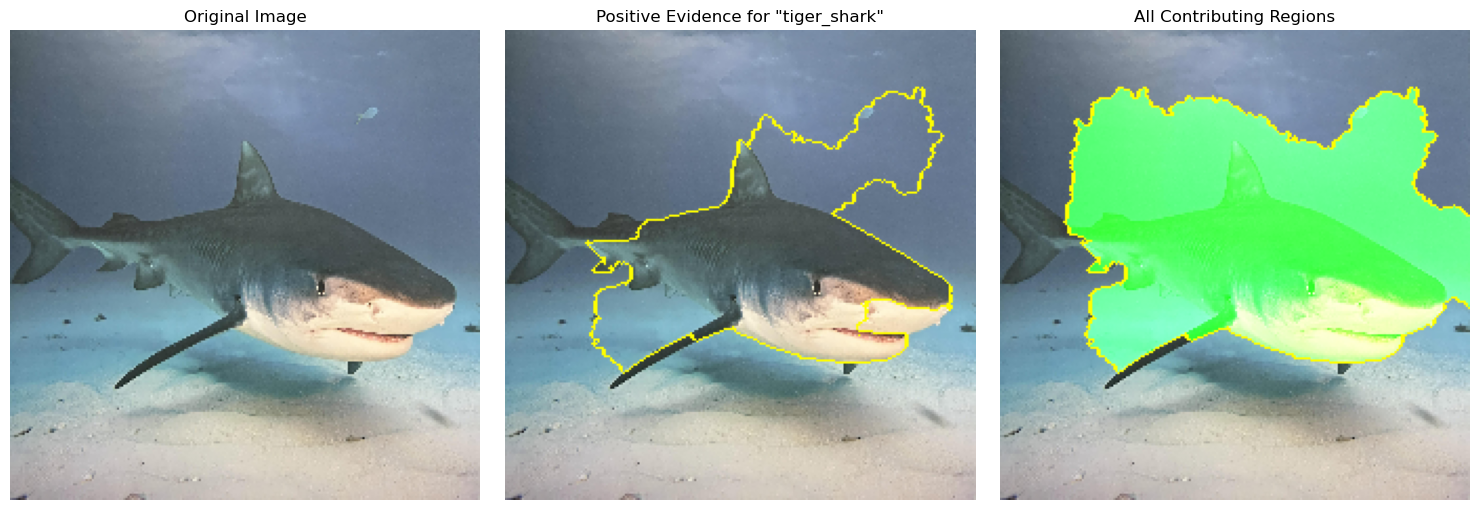


✓ Workflow complete!


(<Functional name=resnet50, built=True>,
 <lime.lime_image.ImageExplanation at 0x1add30bc450>)

In [2]:
complete_lime_workflow('c:/users/hlmas/Desktop/MSc/Ethics/MSc-Ethics/shark.jpg', 'ResNet50')

Starting LIME workflow with INCEPTION_V3...
✓ Loaded inception_v3 model
✓ Loaded and preprocessed image
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

inception_v3 Predictions:
  1. tiger_shark: 95.52%
  2. great_white_shark: 0.35%
  3. scale: 0.34%
  4. hammerhead: 0.05%
  5. scuba_diver: 0.03%

✓ Generating LIME explanation for 'tiger_shark'...


  0%|          | 0/1000 [00:00<?, ?it/s]

✓ Creating visualization...


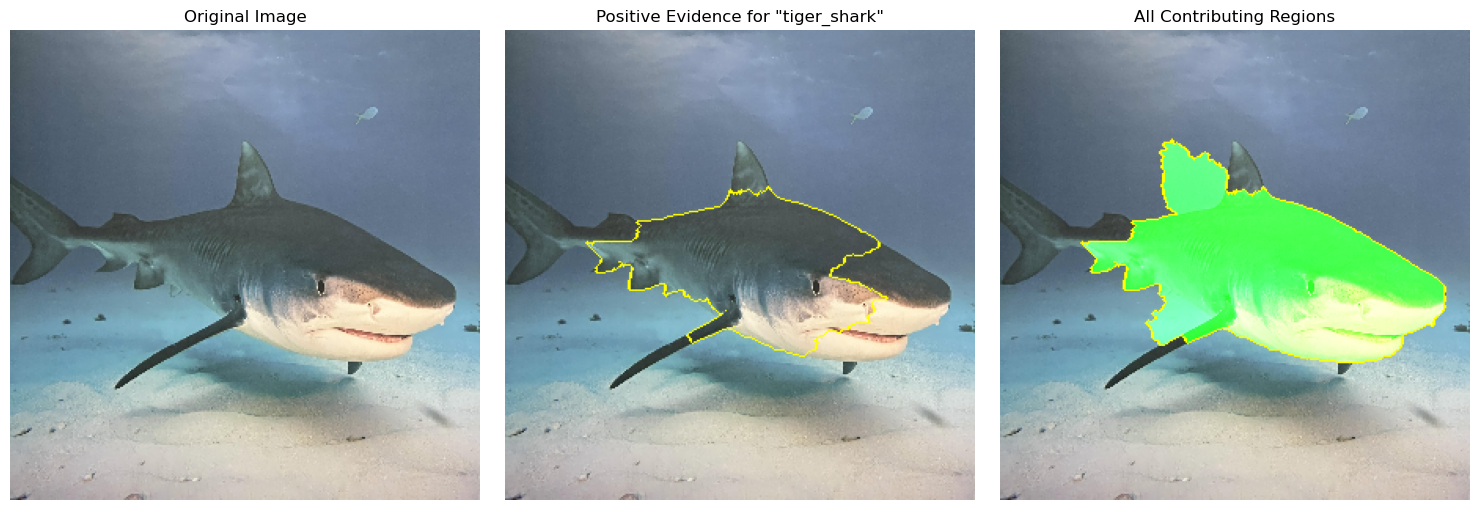


✓ Workflow complete!


(<Functional name=inception_v3, built=True>,
 <lime.lime_image.ImageExplanation at 0x1add7210250>)

In [5]:
complete_lime_workflow('c:/users/hlmas/Desktop/MSc/Ethics/MSc-Ethics/shark.jpg', 'inception_v3')

Starting LIME workflow with VGG16...
✓ Loaded VGG16 model
✓ Loaded and preprocessed image
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step

VGG16 Predictions:
  1. tiger_shark: 96.43%
  2. great_white_shark: 3.46%
  3. hammerhead: 0.09%
  4. stingray: 0.01%
  5. sturgeon: 0.00%

✓ Generating LIME explanation for 'tiger_shark'...


  0%|          | 0/1000 [00:00<?, ?it/s]

✓ Creating visualization...


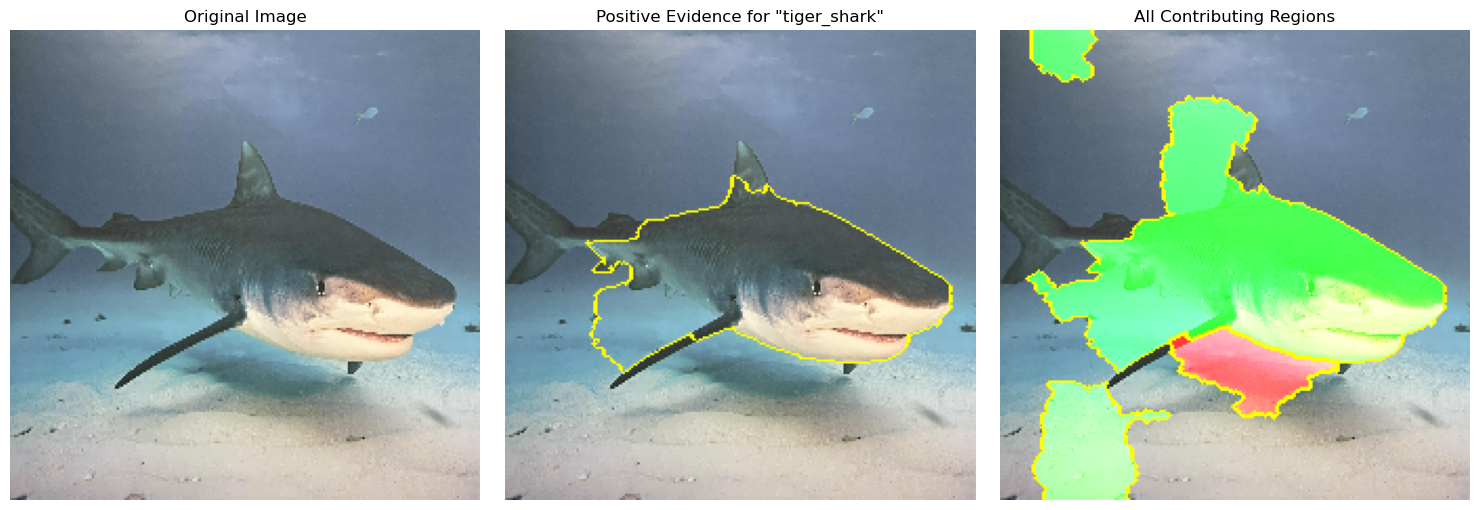


✓ Workflow complete!


(<Functional name=vgg16, built=True>,
 <lime.lime_image.ImageExplanation at 0x1ae61401f90>)

In [6]:
complete_lime_workflow('c:/users/hlmas/Desktop/MSc/Ethics/MSc-Ethics/shark.jpg', 'VGG16')

Starting LIME workflow with VGG19...
✓ Loaded vgg19 model
✓ Loaded and preprocessed image
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step

vgg19 Predictions:
  1. tiger_shark: 93.59%
  2. great_white_shark: 6.26%
  3. hammerhead: 0.14%
  4. coho: 0.00%
  5. sturgeon: 0.00%

✓ Generating LIME explanation for 'tiger_shark'...


  0%|          | 0/1000 [00:00<?, ?it/s]

✓ Creating visualization...


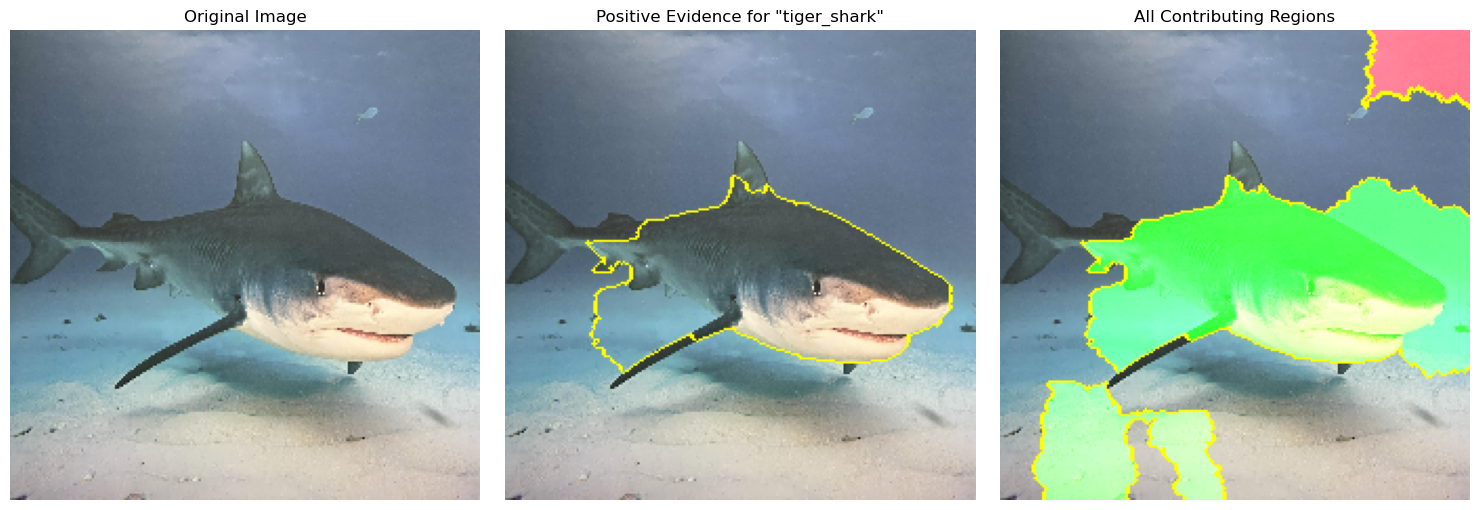


✓ Workflow complete!


(<Functional name=vgg19, built=True>,
 <lime.lime_image.ImageExplanation at 0x1aeb9b2be10>)

In [7]:
complete_lime_workflow('c:/users/hlmas/Desktop/MSc/Ethics/MSc-Ethics/shark.jpg', 'vgg19')

Starting LIME workflow with XCEPTION...
✓ Loaded Xception model
✓ Loaded and preprocessed image
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

Xception Predictions:
  1. tiger_shark: 90.88%
  2. great_white_shark: 0.45%
  3. scuba_diver: 0.13%
  4. hammerhead: 0.10%
  5. sturgeon: 0.06%

✓ Generating LIME explanation for 'tiger_shark'...


  0%|          | 0/1000 [00:00<?, ?it/s]

✓ Creating visualization...


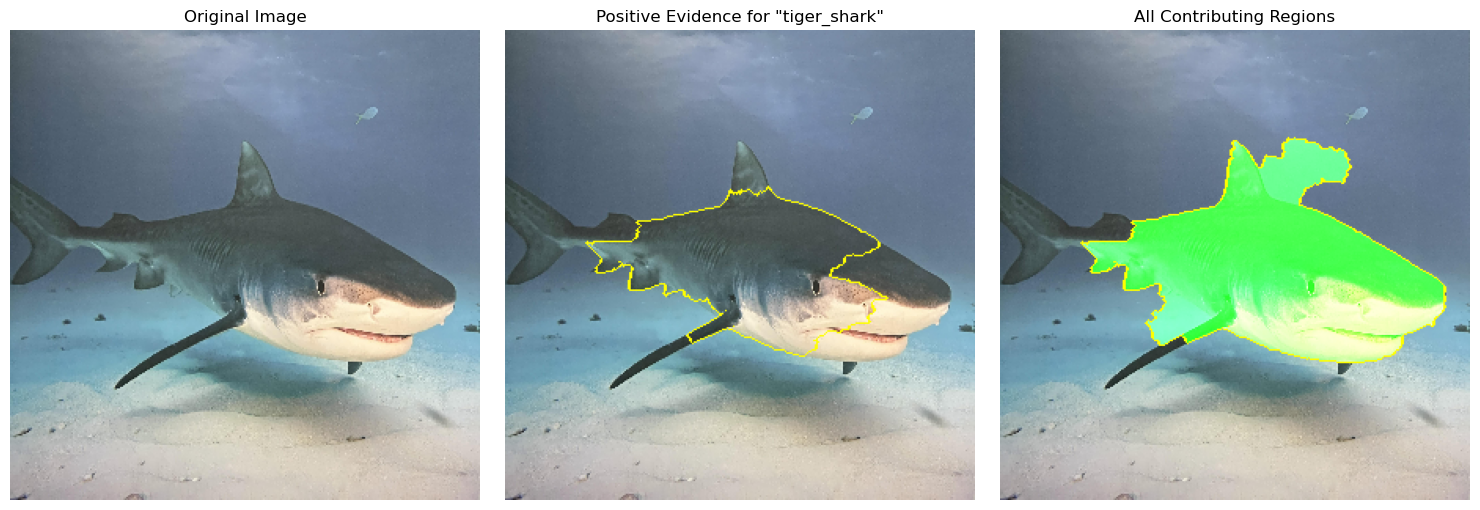


✓ Workflow complete!


(<Functional name=xception, built=True>,
 <lime.lime_image.ImageExplanation at 0x1ae8abfc250>)

In [8]:
complete_lime_workflow('c:/users/hlmas/Desktop/MSc/Ethics/MSc-Ethics/shark.jpg', 'Xception')